# Notebook to Preprocess MIMIC-III v1.4 Data Files

In this notebook we will preprocess the [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) v1.4 data files as extracted by [MIMIC-Code](https://github.com/MIT-LCP/mimic-code). Here, we implement the preprocessing for the *handcrafted state-space approach* as used by [Roggeveen et al.](https://www.sciencedirect.com/science/article/pii/S0933365720312689), by aggregating measurements into bins of 4-hours starting from the 24 hour prior to sepsis onset to 48 hours after (72 hours in total).

The [original notebook](https://github.com/LucaMD/SRL/blob/master/SEPSIS/MIMIC_src/MIMIC_R_DataPreprocessing.ipynb) used to preprocess the datafiles was written in R; I have reimplemented the preprocessing in Python and validated this reimplementation with the original (minus small errors made in the original which I corrected, see `# Remark:` comments in the code cells below).

Moreover, the original notebook restricted the preprocessing to records stored in the MetaVision file system as CareVue files were assumed not to contain the necessary `starttimes` for treatments. Although this is partially true, using additonal preprocessing in `convert_cv_to_mv.ipynb` we were able to reconstruct the `starttimes` for CareVue records (as described in the [MIMIC-III docs](https://mimic.mit.edu/docs/iii/about/io/)), allowing us to expand our sepsis cohort with additional patients.

In [1]:
## Dependencies
# I/O
import os
import re
import pickle
import pandas as pd
import numpy as np

# Plotting
import random
import matplotlib.pyplot as plt

# Timing
from datetime import timedelta
from tqdm import tqdm

# Imputation
from fancyimpute import KNN

# Settings
INTERVAL_TIME = '4h'
USE_CAREVUE = True
DATA_DIR = '../data/mimic-iii/final/'        # Where mimic-iii is kept
OUTPUT_DIR = 'datasets/mimic-iii/roggeveen'  # Where preprocessed data will be stored

In [2]:
# Check if mimic-iii folder exists
if not os.path.exists(DATA_DIR):
    raise Exception('Dataset directory %s does not exist!' % DATA_DIR)

# Create OUTPUT_DIR
OUTPUT_DIR = OUTPUT_DIR + '_%s%s/' % (INTERVAL_TIME, '_with_cv' if USE_CAREVUE else '')
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

**Convenience functions**<br>
For simplicity, we define a number of convenience functions we can reuse throughout the notebook (for loading data, plotting, unit conversions, etc.);

In [3]:
# reads a .csv file and parses datetime columns using pd.to_datetime()
def read_csv(fname):
    df = pd.read_csv(fname)
    
    # Mad explicit as parse_dates=True fails to cast starttime and endtime as timestamps
    parse_dates = ['intime', 'outtime', 'starttime', 'endtime', 'window_start', 
                   'window_end', 'charttime', 'suspected_infection_time_poe']
    
    for col in parse_dates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df

# plots values of under `key` over time
def plot_single(dct, key, title='', xlabel='Timestep', ylabel='Value', style='.-'):
    icustay_id = None
    x = None
    y = None
    
    icustay_ids = list(dct.keys())
    while x is None:
        # Pick a random ICU stay from dct
        icustay_id = random.choice(icustay_ids)
        
        # Continue if no data logged for key
        if key not in dct[icustay_id]:
            continue
        
        # Continue if values are all zeros/NaNs (e.g. to mark no fluids were administered)
        data = np.nan_to_num(dct[icustay_id][key])
        if np.max(data) > 0:
            x = dct[icustay_id]['timestep'][1:]
            y = data
                            
    plt.figure(figsize=(8, 3))
    plt.plot(x, y, style, label=str(icustay_id))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Converts a series of deltatime objects into hours
def to_hours(x):
    return x.astype('timedelta64[s]').astype(int) / 3600

# Converts upper- or camelcase to snake-case (lowercase with '_' separators)
def to_snakecase(string):
    if string.islower():
        return string
    elif string.isupper():
        return string.lower()
    else:
        string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
        return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()
    
print('HeartRate => %s' % to_snakecase('HeartRate'))
print('ALBUMIN   => %s' % to_snakecase('ALBUMIN'))
print('MeanBP    => %s' % to_snakecase('MeanBP'))

HeartRate => heart_rate
ALBUMIN   => albumin
MeanBP    => mean_bp


---
## Patient Cohort

Using MIMIC-Code we have extracted a *sepsis-3* cohort (i.e. a list of patients satisfying the sepsis-3 criteria (Singer et al., 2016)) along with information regarding the suspected time of infection and in-hospital mortality. Let's first import these data;

In [4]:
cohort_df = read_csv(DATA_DIR + 'cohort.csv')
print('Number of admissions: %s\n' % len(cohort_df))
cohort_df.head()

Number of admissions: 18346



,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,55597,189080,226090,2122-04-13 22:38:32,2122-04-14 18:26:03,2122-04-13 21:35:00,2122-04-12 21:35:00,2122-04-15 21:35:00,0
1,6645,177907,205861,2105-07-11 21:28:35,2105-07-13 17:13:43,2105-07-11 00:00:00,2105-07-10 00:00:00,2105-07-13 00:00:00,0
2,30496,165002,281987,2194-06-18 14:03:07,2194-06-19 21:35:23,2194-06-18 00:00:00,2194-06-17 00:00:00,2194-06-20 00:00:00,0
3,92531,184997,218267,2171-07-10 15:10:29,2171-07-11 14:20:11,2171-07-10 11:40:00,2171-07-09 11:40:00,2171-07-12 11:40:00,0
4,28677,159991,282170,2122-12-31 09:28:43,2123-01-01 21:25:41,2122-12-31 18:25:00,2122-12-30 18:25:00,2123-01-02 18:25:00,0


**Sanity check: limit admissions to SOFA $\geq$ 2**

In [5]:
# Remark: The original notebook uses SOFA>3, yet the paper mentions the standard SOFA>=2 as the selection criterion
demo_df = read_csv(DATA_DIR + 'demographics_cohort.csv')
sofa2_icustays = set([row['icustay_id'] for _, row in demo_df.iterrows() if row['sofa'] >= 2])

# Filter cohort
cohort_df = cohort_df[cohort_df['icustay_id'].isin(sofa2_icustays)]

In [6]:
icustay_ids = cohort_df['icustay_id'].values
print('Total number of admissions: %s' % icustay_ids.size) # few are dropped still

Total number of admissions: 18091


**Collecting the data in `data_all`**<br>
For convenience, we will collect features in a dictionary `data_all`, mapping from each admission (`icustay_id`) to the corresponding time series data of each feature (e.g. `heart+rate`, `sys_bp`, `total_iv_fluid`, `wbc`) or action (e.g. `max_vaso`);

In [7]:
# We will store our data in this
data_all = {icustay_id:dict() for icustay_id in cohort_df['icustay_id'].values}

# See? empty...
assert data_all[255559] == {}

---

## 4-Hour Time Intervals

For each 72-hour time window (spanning 24h prior to sepsis onset to 48h after) we will precompute all intermediate timesteps in increments of $\Delta t=4$ hours (defined by `INTERVAL_TIME`). Each time we add our output to `data_all`;

In [8]:
def date_range(icustay, freq):
    starttime = icustay['window_start']
    endtime = icustay['window_end']
    return pd.date_range(start=starttime, end=endtime, freq=freq).values
    
icustay_timesteps = {icustay['icustay_id']: date_range(icustay, freq=INTERVAL_TIME) for _, icustay in cohort_df.iterrows()}

In [9]:
for icustay_id, timesteps in icustay_timesteps.items():
    data_all[icustay_id]['timestep'] = timesteps

In [10]:
# Plot timesteps of random admission
data_all[255559]

{'timestep': array(['2150-09-15T16:12:00.000000000', '2150-09-15T20:12:00.000000000',
        '2150-09-16T00:12:00.000000000', '2150-09-16T04:12:00.000000000',
        '2150-09-16T08:12:00.000000000', '2150-09-16T12:12:00.000000000',
        '2150-09-16T16:12:00.000000000', '2150-09-16T20:12:00.000000000',
        '2150-09-17T00:12:00.000000000', '2150-09-17T04:12:00.000000000',
        '2150-09-17T08:12:00.000000000', '2150-09-17T12:12:00.000000000',
        '2150-09-17T16:12:00.000000000', '2150-09-17T20:12:00.000000000',
        '2150-09-18T00:12:00.000000000', '2150-09-18T04:12:00.000000000',
        '2150-09-18T08:12:00.000000000', '2150-09-18T12:12:00.000000000',
        '2150-09-18T16:12:00.000000000'], dtype='datetime64[ns]')}

---
## Vasopressors

### 1. MetaVision Records

In [11]:
# Load data file from MIMIC-Code
vaso_mv_df = read_csv(DATA_DIR + 'vassopressors_mv_cohort.csv')
vaso_mv_df.head()

,icustay_id,starttime,endtime,rate,rateuom,patientweight,orderid,linkorderid,vasoactive_drug,mcgkgmin,mcgmin
0,200063,2141-03-21 11:00:00,2141-03-21 14:14:00,0.312876,mcg/kg/min,131.8,8935976,8935976,norepinephrine,0.312876,41.237116
1,200063,2141-03-21 14:14:00,2141-03-21 14:41:00,0.300485,mcg/kg/min,131.8,5139193,5139193,norepinephrine,0.300485,39.603961
2,200063,2141-03-21 14:41:00,2141-03-21 15:00:00,0.401104,mcg/kg/min,131.8,8037665,5139193,norepinephrine,0.401104,52.865445
3,200063,2141-03-21 15:00:00,2141-03-21 15:27:00,0.301501,mcg/kg/min,131.8,6825847,5139193,norepinephrine,0.301501,39.737781
4,200063,2141-03-21 15:27:00,2141-03-21 18:27:00,0.200936,mcg/kg/min,131.8,5209279,5139193,norepinephrine,0.200936,26.483338


**Computing maximum vasopressor dose**<br>

For each admission (i.e. ICU stay), we iterate over timesteps $t$ and determine which treatments overlap with its immediate 4 hour history (i.e. which treatments occurred between 4 hours ago and now). We then record the maximum rate of these treatments.

In [12]:
# Consider ICU stays one-by-one
for icustay_id, treatments in tqdm(vaso_mv_df.groupby('icustay_id')):
    
    # Is patient part of cohort?
    if icustay_id not in data_all:
        continue
        
    # To store vasopressor doses into
    timesteps = icustay_timesteps[icustay_id]
    max_vaso = np.full(len(timesteps) - 1, np.nan)
    
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: treatment time overlaps with current interval.
        # Remark: original R-code erroneously used 'treatment[endtime] <= interval_end' as first term
        condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)
        
        # Compute max vasopressor intake in mcg/kg/min (norepinephrine-equivalent)
        max_vaso[i] = treatments[condition]['mcgkgmin'].max()
        
        # Set low treatment amounts to zero (see Roggeveen et al.)
        # Remark: Why drop low treatment doses?
        if max_vaso[i] <= 1e-2:
            max_vaso[i] = 0.0 
        
    data_all[icustay_id]['max_vaso'] = max_vaso
    
del vaso_mv_df

100%|██████████████████████████████████████████████████████████████████████████████| 4137/4137 [00:58<00:00, 71.03it/s]


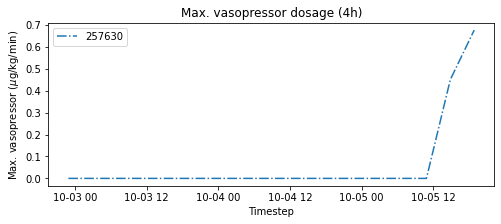

In [13]:
# Plot vasopressors of random admission
plot_single(data_all, key='max_vaso', title='Max. vasopressor dosage (%s)' % INTERVAL_TIME, ylabel='Max. vasopressor ($\mu$g/kg/min)', style='-.')

**Sanity checks**

In [14]:
# How many admissions have vasopressor registered?
sum([1 if 'max_vaso' in adm else 0 for adm in data_all.values()])

4131

In [15]:
# Does the action space look like Roggeveen te al?
max_vasos = np.row_stack([adm['max_vaso'] for _, adm in data_all.items() if 'max_vaso' in adm])
np.nanquantile(max_vasos, np.linspace(0, 1, 5)).round(3) # Approved!

array([0.00000e+00, 1.13000e-01, 2.25000e-01, 4.50000e-01, 2.22731e+02])

### 2. CareVue Records (optional)

In case `USE_CAREVUE` is enabled, we repeat the above process for the (converted) CareVue files.

In [16]:
if USE_CAREVUE:
    # Load preprocessed CV vasopressor file
    vaso_cv_df = read_csv(DATA_DIR + 'vassopressors_cv_cohort_v2.csv')
    vaso_cv_df.head()
    
    for icustay_id, treatments in tqdm(vaso_cv_df.groupby('icustay_id')):

        # Is patient part of cohort?
        if icustay_id not in data_all:
            continue
            
        # Skip if already stored in MV
        if 'max_vaso' in data_all[icustay_id]:
            continue

        # To store vasopressor doses into
        timesteps = icustay_timesteps[icustay_id]
        max_vaso = np.full(len(timesteps) - 1, np.nan)

        for i, interval_start in enumerate(timesteps[:-1]):
            interval_end = timesteps[i + 1]

            # Inclusion test: treatment time overlaps with current interval.
            condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)

            # Compute max vasopressor intake in mcg/kg/min (norepinephrine-equivalent)
            max_vaso[i] = treatments[condition]['mcgkgmin'].max()

            if max_vaso[i] <= 1e-2:
                max_vaso[i] = 0.0 

        data_all[icustay_id]['max_vaso_cv'] = max_vaso  # Mark it has been logged by CV

    del vaso_cv_df

100%|██████████████████████████████████████████████████████████████████████████████| 3898/3898 [00:54<00:00, 72.14it/s]


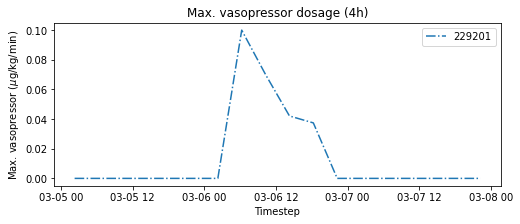

In [17]:
# Plot vasopressors of random admission stored in CV
if USE_CAREVUE:
    plot_single(data_all, key='max_vaso_cv', title='Max. vasopressor dosage (%s)' % INTERVAL_TIME, ylabel='Max. vasopressor ($\mu$g/kg/min)', style='-.')

In [18]:
# How many admissions have vasopressor registered in CV?
if USE_CAREVUE:
    print(sum([1 if 'max_vaso_cv' in adm else 0 for adm in data_all.values()]))

3875


**Merge with MV**

In [19]:
# Merge CV records with max_vaso logged under MV
if USE_CAREVUE:
    for icustay_id in data_all.keys():
        if 'max_vaso_cv' in data_all[icustay_id]:
            data_all[icustay_id]['max_vaso'] = data_all[icustay_id].pop('max_vaso_cv')
print('Done!')

Done!


---
## IV Fluids

### 1. MetaVision Records

In [20]:
ivfluid_mv_df = read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water)
condition = (ivfluid_mv_df['ordercategoryname'] != '14-Oral/Gastric Intake') & (ivfluid_mv_df['amountuom'] == 'ml')
ivfluid_mv_df = ivfluid_mv_df[condition]

# Sanity check: remove amounts outside (0, 5000) range
ivfluid_mv_df = ivfluid_mv_df[(ivfluid_mv_df['amount'] > 0) & (ivfluid_mv_df['amount'] < 5000)]

# Compute duration in hours
# Remark: original erroneously measured time in a mix of hours and minutes (due to unit='auto')
ivfluid_mv_df['duration'] = to_hours(ivfluid_mv_df['endtime'] - ivfluid_mv_df['starttime'])

# Drop unused columns
ivfluid_mv_df = ivfluid_mv_df[['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'amount', 'duration']]
ivfluid_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,amount,duration
2,23,124321,234044.0,2157-10-21 15:00:00,2157-10-21 15:01:00,200.000000,0.016667
4,23,124321,234044.0,2157-10-21 12:15:00,2157-10-21 13:22:00,13.432238,1.116667
7,23,124321,234044.0,2157-10-21 17:08:00,2157-10-21 18:08:00,49.999999,1.000000
10,23,124321,234044.0,2157-10-22 08:00:00,2157-10-22 08:01:00,200.000000,0.016667
14,23,124321,234044.0,2157-10-22 09:24:00,2157-10-22 09:48:00,1.602968,0.400000


**Computing total intake of IV fluids**<br>
In order to determine the total amount of IV fluid administered within a 4 hour interval, we need to calculate how long a treatment was administered for during an interval; multiplied by the rate (i.e. `amount / duration`) we can infer the total amount administered by each treatment during the current interval. For this we use the `total_admin_in_interval` function below:

In [21]:
# Computes how much of each dose was administered between interval_start and interval_end
def total_admin_in_interval(interval_start, interval_end, treatments):
    dose_start = treatments['starttime']
    dose_end = treatments['endtime']
    amount = treatments['amount']
    duration = treatments['duration']
    rate = amount / duration # in ml/hour!   
    
    total_ml = 0
    
    # Option 1: Dose started before interval and ended after interval
    c1 = (dose_start < interval_start) & (dose_end > interval_end)
    if c1.any():
        total_ml += (to_hours(interval_end - interval_start) * rate[c1]).sum()
    
    # Option 2: Dose started before and ended within interval
    c2 = (dose_start < interval_start) & (dose_end > interval_start) & (dose_end <= interval_end)
    if c2.any():
        total_ml += (to_hours(dose_end - interval_start) * rate[c2]).sum()

    # Option 3: Dose started and ended in interval
    c3 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end <= interval_end) & (dose_end > interval_start)
    if c3.any():
        total_ml += amount[c3].sum()
    
    # Option 4: dose started in interval and ended after interval
    # Reamrk: Extra division by duration
    c4 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end > interval_end)
    if c4.any():
        total_ml += (to_hours(interval_end - dose_start) * rate[c4]).sum()
            
    # Return value if there was IV intake, else NaN
    return total_ml if total_ml > 0 else np.NaN

We can now use `total_admin_in_interval()` on each interval `(interval_start, interval_end)` and treatment in `ivfluid_mv_df` to compute the total IV fluid administration within each 4 hour interval:

In [22]:
for icustay_id, treatments in tqdm(ivfluid_mv_df.groupby('icustay_id'), desc='Grab some coffee'):
    
    # Is icustay part of cohort?
    if icustay_id not in data_all:
        continue
    
    # To store fluid intake
    timesteps = icustay_timesteps[icustay_id]
    total_ivfluid = np.full(len(timesteps) - 1, np.nan)
    
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Compute total IV fluid
        total_ivfluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)
        
    # Save!
    data_all[icustay_id]['total_iv_fluid'] = total_ivfluid
    
del ivfluid_mv_df

Grab some coffee: 100%|██████████████████████████████████████████████████████████| 13593/13593 [08:08<00:00, 27.85it/s]


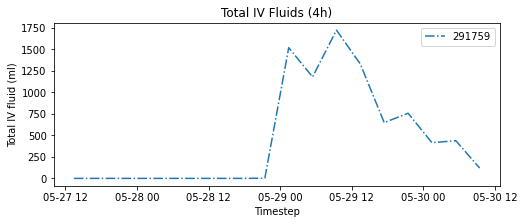

In [23]:
# Show IV fluids from random admission
plot_single(data_all, key='total_iv_fluid', title='Total IV Fluids (%s)' % INTERVAL_TIME, ylabel='Total IV fluid (ml)', style='-.')

**Sanity checks**

In [24]:
# How many admissions have IV fluids registered?
sum([1 if 'total_iv_fluid' in adm else 0 for adm in data_all.values()])

9203

In [25]:
# Does the action space look like Roggeveen te al?
iv_fluids = np.column_stack([adm['total_iv_fluid'] for _, adm in data_all.items() if 'total_iv_fluid' in adm])
np.nanquantile(iv_fluids, np.linspace(0, 1, 5)).round(3) # Checked

array([4.3000000e-02, 1.6252700e+02, 5.0000000e+02, 1.0750000e+03,
       2.5332743e+04])

### 2. CareVue Records (optional)
In case `USE_CAREVUE` is enabled, we repeat the above process for the (converted) CareVue files.

In [26]:
if USE_CAREVUE:
    ivfluid_cv_df = read_csv(DATA_DIR + 'inputevents_cv_cohort_v2.csv')

    # Sanity check: remove amounts outside (0, 5000) range
    # Note: OrderCategoryName->Oral/Gastric and unit = 'ml' already taken care of ;)
    ivfluid_cv_df = ivfluid_cv_df[(ivfluid_cv_df['amount'] > 0) & (ivfluid_cv_df['amount'] < 5000)]

    # Compute duration of IV administration
    ivfluid_cv_df['duration'] = to_hours(ivfluid_cv_df['endtime'] - ivfluid_cv_df['starttime'])
    ivfluid_cv_df.head()
    
    # Resample IV fluids
    for icustay_id, treatments in tqdm(ivfluid_cv_df.groupby('icustay_id'), desc='Grab another coffee'):
    
        if icustay_id not in data_all:
            continue
            
        # Skip if already stored in MV
        if 'total_iv_fluid' in data_all[icustay_id]:
            continue

        # To store fluid intake
        timesteps = icustay_timesteps[icustay_id]
        total_ivfluid = np.full(len(timesteps) - 1, np.nan)

        for i, interval_start in enumerate(timesteps[:-1]):
            interval_end = timesteps[i + 1]

            # Compute total IV fluid
            total_ivfluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)

        # Save!
        data_all[icustay_id]['total_iv_fluid_cv'] = total_ivfluid  # Mark data came from CareVue

    del ivfluid_cv_df

Grab another coffee: 100%|█████████████████████████████████████████████████████████| 8919/8919 [08:35<00:00, 17.31it/s]


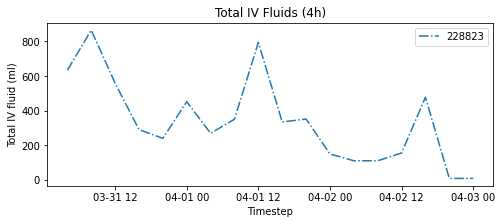

In [27]:
# Show IV fluids from random admission stored in CV
plot_single(data_all, key='total_iv_fluid_cv', title='Total IV Fluids (%s)' % INTERVAL_TIME, ylabel='Total IV fluid (ml)', style='-.')

In [28]:
# How many admissions have IV fluids registered?
sum([1 if 'total_iv_fluid_cv' in adm else 0 for adm in data_all.values()])

8768

**Merge with MV**

In [29]:
# Merge with total_iv_fluid logged by MV
if USE_CAREVUE:
    for icustay_id in data_all.keys():
        if 'total_iv_fluid_cv' in data_all[icustay_id]:
            data_all[icustay_id]['total_iv_fluid'] = data_all[icustay_id].pop('total_iv_fluid_cv')
print('Done!')

Done!


### Running Total

In Roggeveen et al. an additional feature is incorporated which measures the total IV fluid administered up to the current timestep. We implement this here using `np.cumsum` over the previously computed IV fluid balances;

In [30]:
for icustay_id, icustay_data in data_all.items():
    if 'total_iv_fluid' in icustay_data.keys():
        data_all[icustay_id]['running_total_iv_fluid'] = np.cumsum(np.nan_to_num(icustay_data['total_iv_fluid'], nan=0.0))

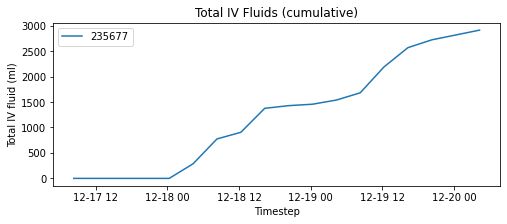

In [31]:
# Grab IV fluids from random patient
plot_single(data_all, key='running_total_iv_fluid', title='Total IV Fluids (cumulative - %s)' % INTERVAL_TIME, ylabel='Total IV fluid (ml)', style='-')

---
## Vital functions

In [32]:
vitals_df = read_csv(DATA_DIR + 'vitals_cohort.csv')
vitals_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,vital_id,valuenum
0,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-16 01:30:00,HeartRate,111.000000
1,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-16 01:30:00,SpO2,98.000000
2,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-16 01:30:00,TempC,37.444445
3,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-16 02:00:00,DiasBP,63.000000
4,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-16 02:00:00,HeartRate,100.000000


In [33]:
# List vitals recorded
ALL_VITALS = list(vitals_df['vital_id'].unique())
print(ALL_VITALS)

['SpO2', 'DiasBP', 'MeanBP', 'TempC', 'SysBP', 'HeartRate', 'Glucose', 'RespRate']


In [34]:
for icustay_id, measurements in tqdm(vitals_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add keys for each vital_id to data_all with empty measurements vector
    timesteps = icustay_timesteps[icustay_id]
    for vital_id in ALL_VITALS:
        data_all[icustay_id][to_snakecase(vital_id)] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] < interval_end)  
        
        # Compute average value of each vital_id
        vital_means = measurements[condition].groupby('vital_id')['valuenum'].mean()
        
        for vital_id, value in vital_means.items():
            data_all[icustay_id][to_snakecase(vital_id)][i] = value
            
del vitals_df

100%|████████████████████████████████████████████████████████████████████████████| 15606/15606 [06:27<00:00, 40.23it/s]


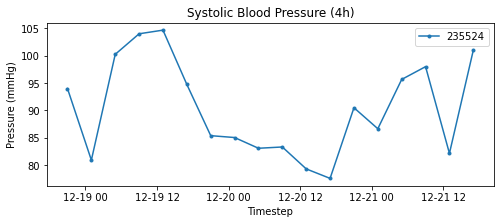

In [35]:
# Show SysBP from random patient
plot_single(data_all, key='sys_bp', title='Systolic Blood Pressure (%s)' % INTERVAL_TIME, ylabel='Pressure (mmHg)')

---
## Lab Results

In [36]:
lab_df = read_csv(DATA_DIR + 'labs_cohort.csv')

# Drop rows with NaNs
lab_df = lab_df.dropna(axis=0)

lab_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,lab_id,valuenum
0,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-15 14:12:00,ALAT,28.0
1,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-15 14:12:00,ANION GAP,17.0
2,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-15 14:12:00,ASAT,69.0
3,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-15 14:12:00,BICARBONATE,24.0
4,4,185777,294638,2191-03-15,2191-03-18,2191-03-16 00:29:31,2191-03-17 16:46:31,2191-03-15 14:12:00,BILIRUBIN,2.2


In [37]:
# List hormones / fluids measured
ALL_LAB_IDS = list(lab_df['lab_id'].unique())
print(ALL_LAB_IDS) 

['HEMOGLOBIN', 'BANDS', 'ASAT', 'LACTATE', 'ION_CALCIUM', 'ALAT', 'POTASSIUM', 'PLATELET', 'PAO2', 'PACO2', 'ANION GAP', 'CREATININE', 'WBC', 'PT', 'BUN', 'MAGNESIUM', 'ALBUMIN', 'PH', 'BaseExcess', 'SODIUM', 'CALCIUM', 'GLUCOSE', 'CHLORIDE', 'PTT', 'BICARBONATE', 'BILIRUBIN']


In [38]:
# Bin lab results into intervals
for icustay_id, lab_results in tqdm(lab_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add lab IDs to `data_all` to store aggregated lab measurements
    timesteps = icustay_timesteps[icustay_id]
    for lab_id in ALL_LAB_IDS:
        if lab_id not in data_all: # glucose is also measured more frequently as a vital
            data_all[icustay_id][to_snakecase(lab_id)] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (lab_results['charttime'] > interval_start) & (lab_results['charttime'] <= interval_end)  
        
        # Compute average value of each lab ID
        lab_means = lab_results[condition].groupby('lab_id')['valuenum'].mean()
        
        for item_id, value in lab_means.items():
            data_all[icustay_id][to_snakecase(item_id)][i] = value
            
del lab_df

100%|████████████████████████████████████████████████████████████████████████████| 17106/17106 [07:34<00:00, 37.64it/s]


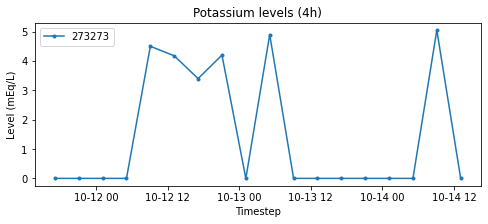

In [39]:
# Show potassium levels from random patient
plot_single(data_all, key='potassium', title='Potassium levels (%s)' % INTERVAL_TIME, ylabel='Level (mEq/L)', style='.-')

Note the many missing values we have, i.e. gaps in the plot above, even when we plot the most frequently measured lab item (`potassium`) and bin these measurements into intervals of 4 hours.

---
## Urine Output

In [40]:
urine_df = read_csv(DATA_DIR + 'urineoutput_cohort.csv')

# Sanity check: drop values exceeding 5000
urine_df = urine_df[(urine_df['value'] > 0) & (urine_df['value'] < 5000)]

urine_df.head()

,subject_id,hadm_id,icustay_id,charttime,value
0,20944,177500,205353,2140-12-01 02:00:00,5.0
1,15185,120114,210804,2132-06-03 08:00:00,100.0
2,11483,180774,236794,2100-11-01 01:00:00,150.0
3,10624,151346,247650,2141-08-23 18:00:00,160.0
4,9021,178275,233215,2167-07-28 07:00:00,45.0


In [41]:
for icustay_id, measurements in tqdm(urine_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in data_all:
        continue
        
    # Add urine output to `data_all` to store aggregated urine measurements
    timesteps = icustay_timesteps[icustay_id]
    data_all[icustay_id]['total_urine_output'] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] <= interval_end)  
        
        # Compute total value within timestep
        data_all[icustay_id]['total_urine_output'][i] = measurements[condition]['value'].sum()
        
del urine_df

100%|████████████████████████████████████████████████████████████████████████████| 15024/15024 [03:29<00:00, 71.80it/s]


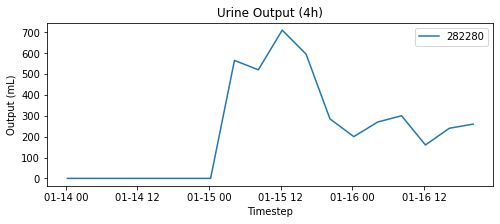

In [42]:
# Grab urine output from random patient
plot_single(data_all, key='total_urine_output', title='Urine Output (%s)' % INTERVAL_TIME, ylabel='Output (mL)', style='-')

### Running Total

In Roggeveen et al. an additional feature `running_total_urine_output` is included in the feature set;

In [43]:
for icustay_id, icustay_data in data_all.items():
    if 'total_urine_output' in icustay_data.keys():
        data_all[icustay_id]['running_total_urine_output'] = np.cumsum(icustay_data['total_urine_output'])

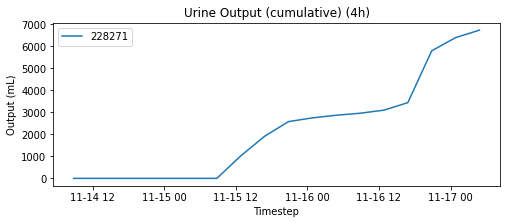

In [44]:
# Grab urine output from random patient
plot_single(data_all, key='running_total_urine_output', title='Urine Output (cumulative) (%s)' % INTERVAL_TIME, ylabel='Output (mL)', style='-')

---
## FiO2 (Fraction of Inspired Oxygen)

In [45]:
fio2_df = read_csv(DATA_DIR + 'fio2_cohort.csv')
fio2_df.head()

,subject_id,hadm_id,icustay_id,charttime,fio2
0,4,185777,294638,2191-03-16 03:00:00,94.999999
1,4,185777,294638,2191-03-16 08:00:00,50.000000
2,4,185777,294638,2191-03-16 11:00:00,NaN
3,9,150750,220597,2149-11-09 13:40:00,NaN
4,9,150750,220597,2149-11-09 17:00:00,60.000002


In [46]:
# Process ICU stays one-by-one
for icustay_id, measurements in tqdm(fio2_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Add FiO2 ID to `data_all` to store aggregated measurements
    timesteps = icustay_timesteps[icustay_id]
    data_all[icustay_id]['fi_o2'] = np.full(len(timesteps) - 1, np.nan)
            
    for i, interval_start in enumerate(timesteps[:-1]):
        interval_end = timesteps[i + 1]
        
        # Inclusion test: charttime in (interval_start, interval_end)
        condition = (measurements['charttime'] > interval_start) & (measurements['charttime'] <= interval_end)  
        
        # Compute average value within timestep
        data_all[icustay_id]['fi_o2'][i] = measurements[condition]['fio2'].mean()
        
del fio2_df

100%|████████████████████████████████████████████████████████████████████████████| 10215/10215 [02:18<00:00, 73.70it/s]


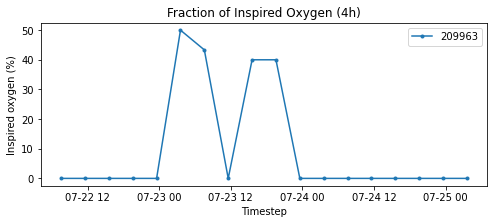

In [47]:
# Grab FiO2 from random patient
plot_single(data_all, key='fi_o2', title='Fraction of Inspired Oxygen (%s)' % INTERVAL_TIME, ylabel='Inspired oxygen (%)')

---
## Demographics

In [48]:
demo_df = pd.read_csv(DATA_DIR + 'demographics_cohort.csv')
demo_df.head()

,subject_id,hadm_id,icustay_id,age,is_male,race_white,race_black,race_hispanic,race_other,height,...,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,elixhauser_hospital,blood_culture_positive
0,27513,163557,200003,48.2940,1,1,0,0,0,177.80,...,1,6,3,4,2,1.0,0.0,1.0,0,1
1,9514,127229,200014,84.7274,1,0,0,0,1,167.64,...,1,3,5,4,2,1.0,0.0,1.0,0,1
2,21789,112486,200019,82.8820,0,1,0,0,0,NaN,...,1,5,7,3,2,0.0,1.0,1.0,0,1
3,14987,165426,200030,54.1915,1,0,1,0,0,187.96,...,0,7,4,4,2,1.0,0.0,1.0,9,1
4,46489,152416,200035,30.6591,1,0,1,0,0,NaN,...,0,2,1,3,1,0.0,0.0,1.0,2,0


In [49]:
# Define demographics and disease severity scores of interest (on admission)
DEMOGRAPHICS_COLS = ['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs']

In [50]:
for icustay_id, demographics in tqdm(demo_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    timesteps = icustay_timesteps[icustay_id]
    N = len(timesteps) - 1
    
    # Repeat demographics at each timestep
    for feature in DEMOGRAPHICS_COLS:
        data_all[icustay_id][feature] = np.ones(N) * demographics[feature].values[0]
        
del demo_df

100%|██████████████████████████████████████████████████████████████████████████| 18346/18346 [00:06<00:00, 2713.01it/s]


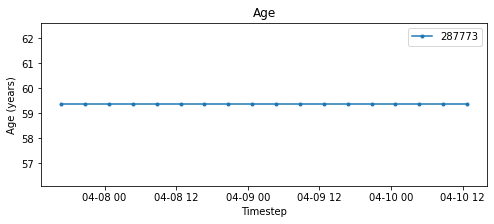

In [51]:
plot_single(data_all, key='age', title='Age', ylabel='Age (years)')

---
# Putting It All Together!

## Add Reward
We define positive terminal reward (R=15) as discharge of patient (survival beyond hospital stay) and negative reward (R=-15) for the passing of the patient in-hospital. No intermediate rewards are issued.

In [52]:
# Dict mapping from patient to 30-day mortality
mortality_dct = {row['icustay_id']:row['hospital_expire_flag'] for _, row in cohort_df.iterrows()}

# Process ICU stays one-by-one
for icustay_id, patient in tqdm(cohort_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in icustay_timesteps:
        continue
        
    # Determine whether person passed away in hospital
    timesteps = icustay_timesteps[icustay_id]
    deceased = mortality_dct[icustay_id]
    
    # Define reward as +15 if survived; -15 otherwise; no intermediate rewards
    rewards = np.zeros(len(timesteps) - 1)
    rewards[-1] = 15 if not deceased else -15
    
    data_all[icustay_id]['reward'] = rewards

100%|█████████████████████████████████████████████████████████████████████████| 18091/18091 [00:00<00:00, 37863.60it/s]


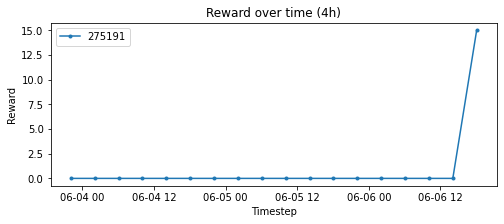

In [53]:
# Grab Reward trajectory from random patient
plot_single(data_all, key='reward', title='Reward over time (%s)' % INTERVAL_TIME, ylabel='Reward')

## Shift Actions in Time by One Timestep
By dropping the first value (and appending a `NaN` at the end) we effectively shift the reward signal, vasopressor doses and IV fluid intake one time-step back (giving us a state representation, action and the associated reward all in the same DataFrame row once we cast `data_all` to a pandas DataFrame);

In [54]:
for icustay_id, icustay_data in data_all.items():
    
    # Shift actions and reward sequence forward by one
    if 'total_iv_fluid' in data_all[icustay_id]:
        data_all[icustay_id]['total_iv_fluid_shifted'] = list(data_all[icustay_id]['total_iv_fluid'][1:]) + [np.NaN]
        
    if 'max_vaso' in data_all[icustay_id]:
        data_all[icustay_id]['max_vaso_shifted'] = list(data_all[icustay_id]['max_vaso'][1:]) + [np.NaN]
        
    if 'reward' in data_all[icustay_id]:
        data_all[icustay_id]['reward_shifted'] = list(data_all[icustay_id]['reward'][1:]) + [np.NaN]
        
print('Done!')

Done!


## Convert to DataFrame!

In [55]:
# Mark measurement by decision time `interval_end` (i.e. drop interval_start)
for icustay_id in data_all.keys():
    data_all[icustay_id]['timestep'] = data_all[icustay_id]['timestep'][1:]

# Convert individual streams into DataFrames
data_all_df = {icustay_id: pd.DataFrame.from_dict(icustay_data) for icustay_id, icustay_data in data_all.items()}

# Add icustay_id as identifier
for icustay_id in data_all_df.keys():
    data_all_df[icustay_id]['icustay_id'] = icustay_id
    
# Merge into one large DataFrame
data_all_df = pd.concat(data_all_df.values()).reset_index()
data_all_df.head()

,index,timestep,total_iv_fluid,running_total_iv_fluid,sp_o2,dias_bp,mean_bp,temp_c,sys_bp,heart_rate,...,weight,vent,sofa,sirs,reward,total_iv_fluid_shifted,reward_shifted,icustay_id,max_vaso,max_vaso_shifted
0,0,2122-04-13 01:35:00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,99.2,0.0,5.0,4.0,0.0,NaN,0.0,226090,NaN,NaN
1,1,2122-04-13 05:35:00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,99.2,0.0,5.0,4.0,0.0,NaN,0.0,226090,NaN,NaN
2,2,2122-04-13 09:35:00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,99.2,0.0,5.0,4.0,0.0,NaN,0.0,226090,NaN,NaN
3,3,2122-04-13 13:35:00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,99.2,0.0,5.0,4.0,0.0,NaN,0.0,226090,NaN,NaN
4,4,2122-04-13 17:35:00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,99.2,0.0,5.0,4.0,0.0,NaN,0.0,226090,NaN,NaN


In [56]:
# For conversion rates see https://github.com/LucaMD/SRL/blob/master/SEPSIS/MIMIC_src/MIMIC_R_DataPreprocessing.ipynb
data_final_df = pd.DataFrame({'icustay_id': data_all_df['icustay_id'], 
                              'timestep': data_all_df['timestep'], 
                              # Discretized 'action' (0 - 24) added below
                              'max_vaso': data_all_df['max_vaso'],
                              'max_vaso_shifted': data_all_df['max_vaso_shifted'],
                              'total_iv_fluid': data_all_df['total_iv_fluid'],
                              'total_iv_fluid_shifted': data_all_df['total_iv_fluid_shifted'],
                              'reward': data_all_df['reward_shifted'],
                              'sirs_score': data_all_df['sirs'],
                              'sofa_score': data_all_df['sofa'],
                              'weight': data_all_df['weight'],
                              'ventilator': data_all_df['vent'],
                              'height': data_all_df['height'],
                              'age': data_all_df['age'],
                              'gender': data_all_df['is_male'],
                              'heart_rate': data_all_df['heart_rate'],
                              'temp': data_all_df['temp_c'],
                              'mean_bp': data_all_df['mean_bp'],
                              'dias_bp': data_all_df['dias_bp'],
                              'sys_bp': data_all_df['sys_bp'],
                              'resp_rate': data_all_df['resp_rate'],
                              'spo2': data_all_df['sp_o2'],
                              'natrium': data_all_df['sodium'],
                              'chloride': data_all_df['chloride'],
                              'kalium': data_all_df['potassium'],
                              'trombo': data_all_df['platelet'],
                              'leu': data_all_df['wbc'],
                              'anion_gap': data_all_df['anion gap'],
                              'aptt': data_all_df['ptt'],
                              'art_ph': data_all_df['ph'],
                              'asat': data_all_df['asat'],
                              'alat': data_all_df['alat'],
                              'bicarbonaat': data_all_df['bicarbonate'],
                              'art_be': data_all_df['base_excess'],
                              'ion_ca': data_all_df['ion_calcium'],
                              'lactate': data_all_df['lactate'],
                              'paco2': data_all_df['paco2'],
                              'pao2': data_all_df['pao2'],
                              'fio2': data_all_df['fi_o2'],
                              'sirs_bands': data_all_df['bands'], # Not part of feature space
                              'shock_index': data_all_df['heart_rate'] / data_all_df['sys_bp'],
                              'hb': data_all_df['hemoglobin'] * 0.6206, # Conversion rates (see original notebook)
                              'bilirubin': data_all_df['bilirubin'] * (1 / 0.05847953),
                              'creatinine': data_all_df['creatinine'] * (1 / 0.01131222),
                              'inr': data_all_df['pt'] / 12,
                              'ureum': data_all_df['bun'] * 0.3571,
                              'albumin': data_all_df['albumin'] * 10,
                              'magnesium': data_all_df['magnesium'] * 0.411,
                              'calcium': data_all_df['calcium'] * 0.25,
                              'pf_ratio': data_all_df['paco2'] / data_all_df['fi_o2'],
                              'glucose': data_all_df['glucose'] * 0.0555,
                              'running_total_urine_output': data_all_df['running_total_urine_output'],
                              'total_urine_output': data_all_df['total_urine_output'],
                              'running_total_iv_fluid': data_all_df['running_total_iv_fluid'],})

In [57]:
# Show data for random patient
icustay_id = 265809
data_final_df[data_final_df['icustay_id'] == icustay_id].tail()

,icustay_id,timestep,max_vaso,max_vaso_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,inr,ureum,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid
273163,265809,2160-02-08 04:05:00,NaN,NaN,50.000002,45.925000,0.0,3.0,2.0,118.0,...,1.166667,10.3559,31.0,0.8631,2.35,NaN,8.32500,2405.0,410.0,1328.017503
273164,265809,2160-02-08 08:05:00,NaN,NaN,45.925000,NaN,0.0,3.0,2.0,118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.43800,2585.0,180.0,1373.942503
273165,265809,2160-02-08 12:05:00,NaN,0.911508,NaN,5538.506985,0.0,3.0,2.0,118.0,...,1.358333,NaN,NaN,NaN,NaN,NaN,11.87700,2585.0,0.0,1373.942503
273166,265809,2160-02-08 16:05:00,0.911508,0.911508,5538.506985,1221.078076,15.0,3.0,2.0,118.0,...,1.258333,9.9988,NaN,NaN,NaN,0.550,9.51825,2965.0,380.0,6912.449488
273167,265809,2160-02-08 20:05:00,0.911508,NaN,1221.078076,NaN,NaN,3.0,2.0,118.0,...,NaN,NaN,NaN,NaN,NaN,0.435,7.68675,3640.0,675.0,8133.527564


## Discretize Action Space

In [58]:
# Compute 5-bin histogram to obtain discrete intervals
def get_quantile_intervals(vals, N=5, max_inf=True, min_inf=True):
    vals = vals[vals > 0].values
    quantiles = [0] + [np.nanquantile(vals, i) for i in np.linspace(0, 1, N)]
    if min_inf:
        quantiles[:2] = [-np.inf, 0]
    if max_inf:
        quantiles[-1] = np.inf
    return quantiles

tot_iv_bins = get_quantile_intervals(data_final_df['total_iv_fluid_shifted'], max_inf=False)
max_vp_bins = get_quantile_intervals(data_final_df['max_vaso_shifted'])

print('Total IV fluid bins: ', tot_iv_bins)
print('Max vasopressor bins:', max_vp_bins)

Total IV fluid bins:  [-inf, 0, 200.0, 464.41352758500005, 909.801980944, 25332.742653704]
Max vasopressor bins: [-inf, 0, 0.1, 0.225, 0.45037192135500004, inf]


<AxesSubplot:>

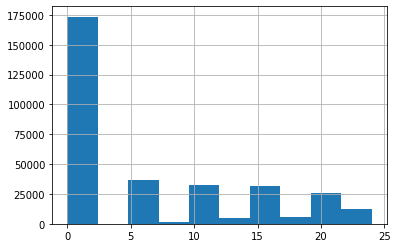

In [59]:
# Replace NaNs by zero (no vasopressor or IV fluid treatment, so dose = zero)
data_final_df['max_vaso'] = data_final_df['max_vaso'].fillna(0)
data_final_df['total_iv_fluid'] = data_final_df['total_iv_fluid'].fillna(0)
data_final_df['max_vaso_shifted'] = data_final_df['max_vaso_shifted'].fillna(0)
data_final_df['total_iv_fluid_shifted'] = data_final_df['total_iv_fluid_shifted'].fillna(0)

# Use pd.cut to discretize actions
max_vp_discrete = pd.cut(data_final_df['max_vaso_shifted'], 
                         right=True,
                         bins=max_vp_bins, 
                         labels=[0, 1, 2, 3, 4]).astype(float)

total_iv_discrete = pd.cut(data_final_df['total_iv_fluid_shifted'],
                           right=True,
                           bins=tot_iv_bins, 
                           labels=[0, 1, 2, 3, 4]).astype(float)

# Compute action as 5 * total_iv_fluid + max_vaso
data_final_df['action'] = 5 * total_iv_discrete + max_vp_discrete
data_final_df['action'].hist(bins=25)

#### Export Action Bins

In [60]:
# Save bin edges of max_vaso and total_iv_fluid as .npy files for later reference
with open(OUTPUT_DIR + 'max_vaso_bins.npy', 'w') as file:
    np.savetxt(file, max_vp_bins)
    
with open(OUTPUT_DIR + 'total_iv_fluid_bins.npy', 'w') as file:
    np.savetxt(file, tot_iv_bins)
    
print('Done!')

Done!


#### Export Map from Actions to IV/Vaso Bins

In [61]:
# Save mapping from action indices (0 to 24) to bin indices (0 to 4)
action_id_to_bins = dict()
for max_vaso in range(5):
    for total_iv_fluid in range(5):
        action_id_to_bins[5 * total_iv_fluid + max_vaso] = (total_iv_fluid, max_vaso)

with open(OUTPUT_DIR + 'action_to_vaso_fluid_bins.pkl', 'wb') as file:
    pickle.dump(action_id_to_bins, file)
print('Done!')

Done!


## Disease Severity Scores (SOFA, qSOFA, SIRS)
For evaluation it is useful to consider not just (q)SOFA scores on admission (see `demographics_cohort.csv`), but also at each state (where possible). This will allow us to analyze the actions taken by the model as a function of disease progression.

In [62]:
# TODO: SOFA and qSOFA (how to get gcs?)

def SIRS(df):
    # Check if all quantities we need are there
    missing = df['temp'].isna() | df['heart_rate'].isna() | (df['resp_rate'].isna() & df['paco2'].isna()) | (df['leu'].isna() & df['sirs_bands'].isna())
    missing = missing.values
    
    # SIRS conditions
    temp = (df['temp'] < 36) | (df['temp'] > 38)
    heart_rate = df['heart_rate'] > 90
    resp_rate = (df['resp_rate'] > 20) | (df['paco2'] < 32)
    leukocytes = (df['leu'] > 12000) | (df['leu'] < 4000) | (df['sirs_bands'] > 10)
    
    # Total SIRS score
    sirs = temp.astype(int) + heart_rate.astype(int) + resp_rate.astype(int) + leukocytes.astype(int)
    sirs = sirs.values
        
    return np.where(missing, -np.ones(sirs.shape), sirs) # -1 in case not computable


data_final_df['state_sirs'] = SIRS(data_final_df)

<AxesSubplot:>

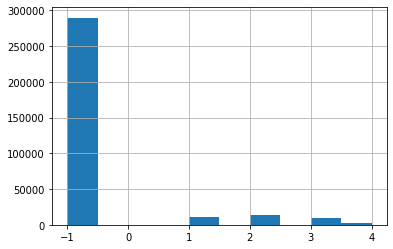

In [63]:
data_final_df['state_sirs'].hist()

## Cap Outlying Measurements

During exploratory data analysis it was found that the data was riddled with measurement errors, whereby treatment and vital parameters would take values orders in magnitude higher than would be possible (or safe practice). To ensure feature normalization will not too much be affected by these values, we will cap values to their respective minimum or maximum when outside of their clinically possible range.

However, slight modifications are made to the capping values used in (Roggeveen et al., 2021)
1. Max. `anion_gap`: 12 $\rightarrow$ 40 (as 12 can be considered an acceptable value for even healthy patients depending on the lab and how the test was performed, see [Wikipedia's entry for Anion Gap](https://en.wikipedia.org/wiki/Anion_gap))
2. Min. `shock_index`: 0.5 $\rightarrow$ 0.4 (a value of 0.5 was very often measured (>22.000) and thus the range was slightly relaxed compared to Roggeveen et al.)

In [64]:
# Load capping values (roggeveen et al., 2021)
min_max_values = pd.read_csv('capping_values.csv').set_index('parameter').to_dict('index')

for feature, rng in min_max_values.items():
    # Cap values with bounds specific to feature
    capped_values = data_final_df[feature].clip(lower=rng['minval'], upper=rng['maxval'])
        
    # Count non-NaN measurements capped
    num_capped = ((capped_values != data_final_df[feature]) * capped_values.notna()).sum()
    
    # Print features for which a lot of values were capped
    if num_capped > 100:
        print(feature, num_capped)
    
    data_final_df[feature] = capped_values

age 432
aptt 251
bilirubin 123
calcium 159
chloride 199
glucose 297
height 378
leu 234
magnesium 157
paco2 1095
pao2 3324
resp_rate 206
shock_index 690
weight 1710


## Drop No-Treatment Admissions

There are many admissions in which no hemodynamic treatments are prescribed; we will filter out these treatments as done in Roggeveen et al.;

In [65]:
# Identify admissions where treatments were registered (at least one action > 0)
admission_has_treatment = data_final_df.groupby('icustay_id', sort=False)['action'].max() > 0
icustay_ids = admission_has_treatment.index[admission_has_treatment.values]

# Drop all non-treatment admissions
data_final_df = data_final_df[data_final_df['icustay_id'].isin(icustay_ids)]

In [66]:
# How many admissions do we have left?
len(data_final_df.icustay_id.unique())

15035

## Training, Validation and Test

To train and test the model we need dedicated training, validation (e.g. for hyperparameter tuning) and test sets. We perform the splitting below;

In [67]:
# For reproduction sake!
random.seed(10)

In [68]:
# Specify fraction of ICU-stays for training, validation and testing
frac_train = 0.7
frac_valid = 0.1

# Randomly assign icustay_ids to train, val and test
icustay_ids = list(data_final_df['icustay_id'].unique())
random.shuffle(icustay_ids)

num_train = int(len(icustay_ids) * frac_train)
num_valid = int(len(icustay_ids) * frac_valid)

train_icustays = icustay_ids[:num_train]
valid_icustays = icustay_ids[num_train:num_train + num_valid]
test_icustays = icustay_ids[num_train + num_valid:]

# Store train/valid/test icustay_ids
np.savetxt(OUTPUT_DIR + 'mimic-iii_icustay_ids_train.npy', train_icustays)
np.savetxt(OUTPUT_DIR + 'mimic-iii_icustay_ids_valid.npy', valid_icustays)
np.savetxt(OUTPUT_DIR + 'mimic-iii_icustay_ids_test.npy', test_icustays)

print('Dataset instances:')
print('Train  %s' % len(train_icustays))
print('Valid  %s' % len(valid_icustays))
print('Test   %s' % len(test_icustays))

Dataset instances:
Train  10524
Valid  1503
Test   3008


In [69]:
data_train_df = data_final_df[data_final_df['icustay_id'].isin(train_icustays)].reset_index(drop=True)
data_valid_df = data_final_df[data_final_df['icustay_id'].isin(valid_icustays)].reset_index(drop=True)
data_test_df = data_final_df[data_final_df['icustay_id'].isin(test_icustays)].reset_index(drop=True)
print('Done!')

Done!


## Feature Normalization
In order to work well with neurla networks we may wish to normlize the input and perform various kinds of transformations (e.g. log transforms). Here we follow Roggeveen et al. and perform the normalization and transformation using a set of *clinically-guided transformations*;

In [70]:
BINARY_FIELDS = ['ventilator', 'gender']
LOG_FIELDS = ['max_vaso', 'spo2', 'ureum', 'creatinine', 'alat', 'asat', 'bilirubin', 'inr', 'running_total_iv_fluid',
              'total_iv_fluid', 'running_total_urine_output', 'total_urine_output']
EXCLUDE = ['icustay_id', 'timestep', 'reward', 'state_sirs', 'action']

### Z-scoring and Log-transforms

In [71]:
# Compute training set averages and stdevs
avgs, stds = dict(), dict()
for col in data_train_df.columns:
    if col not in EXCLUDE:
        avgs[col] = data_train_df[col].mean() # training set mean
        stds[col] = data_train_df[col].std()  # training set std

# Perform normalization with values from data_train_df
for df in [data_train_df, data_valid_df, data_test_df]:
    for col in tqdm(df.columns):
        if col not in EXCLUDE:
            if col in BINARY_FIELDS:
                # Binary
                df[col] = df[col] - 0.5
            elif col in LOG_FIELDS:
                # Log
                df[col] = np.log(0.1 + df[col])
            else:
                # Linear
                df[col] = (df[col] - avgs[col]) / stds[col]
                
print('Done!')

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 971.30it/s]

Done!


### MinMax Normalization
After Z-scoring Roggeveen et al. scales all features using MinMax normalization, which we will repeat for good measure (Although it undoes some of the previous normalization steps);

In [72]:
for col in tqdm(df.columns):
    if col not in EXCLUDE:
        # Min/max estimates from training set!
        train_min = data_train_df[col].min()
        train_max = data_train_df[col].max()
        
        data_train_df[col] = (data_train_df[col] - train_min) / (train_max - train_min)
        data_valid_df[col] = (data_valid_df[col] - train_min) / (train_max - train_min)
        data_test_df[col] = (data_test_df[col] - train_min) / (train_max - train_min)
        
print('Done!')

100%|█████████████████████████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 116.29it/s]

Done!


In [73]:
data_train_df.head()

,icustay_id,timestep,max_vaso,max_vaso_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid,action,state_sirs
0,226090,2122-04-13 01:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
1,226090,2122-04-13 05:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
2,226090,2122-04-13 09:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
3,226090,2122-04-13 13:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
4,226090,2122-04-13 17:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0


## Imputation

### Linear Interpolation
As sometimes only single points are missing between otherwise adjacent measurements we use linear interpolation to fill in these gaps. This prevents the possibility of the kNN imputer (next up) to add noise to these fairly certain values.

In [74]:
INTERP_COLS = ['glucose', 'hb', 'albumin', 'sys_bp', 'art_ph', 'total_urine_output', 'resp_rate', 'bicarbonaat',
               'aptt', 'ureum', 'temp', 'magnesium', 'trombo', 'pao2', 'asat', 'shock_index', 'heart_rate',
               'dias_bp', 'alat', 'sirs_bands', 'creatinine', 'ion_ca', 'art_be', 'paco2', 'inr', 'mean_bp',
               'kalium', 'natrium', 'pf_ratio', 'spo2', 'running_total_urine_output', 'leu', 'lactate', 
               'bilirubin', 'calcium', 'sofa_score', 'chloride', 'anion_gap']

# Interpolate each feature within each ICU stay separately for each dataset
for dataset in [data_train_df, data_valid_df, data_test_df]:
    groups = dataset.groupby('icustay_id', sort=False)
    for col in tqdm(INTERP_COLS):
        dataset[col] = groups[col].apply(lambda group: group.interpolate(method='linear', limit_area='inside', limit=1)) # Max 2 steps apart!
    
data_train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:41<00:00,  1.09s/it]


,icustay_id,timestep,max_vaso,max_vaso_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid,action,state_sirs
0,226090,2122-04-13 01:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
1,226090,2122-04-13 05:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
2,226090,2122-04-13 09:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
3,226090,2122-04-13 13:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0
4,226090,2122-04-13 17:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1.0


### KNN-based Imputation
Some points that are missing lie 'outside' of the measurements (i.e. there is no point to the left or right) or multiple-adjacent values are missing. As there is significant uncertainty with these values we use kNN-based imputation to estimate their value.

In [75]:
IMPUTING_FIELDS = list(set(data_train_df.columns) - set(EXCLUDE))

# Training
for icustay_id in tqdm(train_icustays, desc='train'):
    X_incomplete = data_train_df.loc[data_train_df['icustay_id'] == icustay_id][IMPUTING_FIELDS]
    data_train_df.loc[data_train_df['icustay_id'] == icustay_id, IMPUTING_FIELDS] = KNN(k=3, verbose=False).fit_transform(X_incomplete)
    
# Validation
for icustay_id in tqdm(valid_icustays, desc='valid'):
    X_incomplete = data_valid_df.loc[data_valid_df['icustay_id'] == icustay_id][IMPUTING_FIELDS]
    data_valid_df.loc[data_valid_df['icustay_id'] == icustay_id, IMPUTING_FIELDS] = KNN(k=3, verbose=False).fit_transform(X_incomplete)
    
# Test
for icustay_id in tqdm(test_icustays, desc='test'):
    X_incomplete = data_test_df.loc[data_test_df['icustay_id'] == icustay_id][IMPUTING_FIELDS]
    data_test_df.loc[data_test_df['icustay_id'] == icustay_id, IMPUTING_FIELDS] = KNN(k=3, verbose=False).fit_transform(X_incomplete)

data_train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 3008/3008 [01:21<00:00, 36.85it/s]


,icustay_id,timestep,max_vaso,max_vaso_shifted,total_iv_fluid,total_iv_fluid_shifted,reward,sirs_score,sofa_score,weight,...,albumin,magnesium,calcium,pf_ratio,glucose,running_total_urine_output,total_urine_output,running_total_iv_fluid,action,state_sirs
0,226090,2122-04-13 01:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,0.5,0.289699,0.662135,0.0,0.219978,0.0,0.0,0.0,0.0,-1.0
1,226090,2122-04-13 05:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,0.5,0.289699,0.662135,0.0,0.219978,0.0,0.0,0.0,0.0,-1.0
2,226090,2122-04-13 09:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,0.5,0.289699,0.662135,0.0,0.219978,0.0,0.0,0.0,0.0,-1.0
3,226090,2122-04-13 13:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,0.5,0.289699,0.662135,0.0,0.219978,0.0,0.0,0.0,0.0,-1.0
4,226090,2122-04-13 17:35:00,0.0,0.0,0.0,0.0,0.0,1.0,0.157895,0.227692,...,0.5,0.289699,0.662135,0.0,0.219978,0.0,0.0,0.0,0.0,-1.0


## Rename Columns to `X*`

In the source code we may wish to refer to the list of features without defining the names of the features each time, i.e. `['heart_rate', 'albumin', 'leu', 'resp_rate', 'fio2', ...]` etc. Much easier is to simply refer to the columns as `x0` to `x49` which we can create procedurally. Below we will define a mapping from state-space features to their `x*`equivalents;

In [76]:
STATE_SPACE_COLUMNS = ['max_vaso', 'total_iv_fluid', 'sirs_score', 'sofa_score', 'weight', 'ventilator', 'height', 'age', 'gender',
                       'heart_rate', 'temp', 'mean_bp', 'dias_bp', 'sys_bp', 'resp_rate', 'spo2', 'natrium', 'chloride', 'kalium', 'trombo', 
                       'leu', 'anion_gap', 'aptt', 'art_ph', 'asat', 'alat', 'bicarbonaat', 'art_be', 'ion_ca', 'lactate', 'paco2', 'pao2', 
                       'fio2', 'sirs_bands', 'shock_index', 'hb', 'bilirubin', 'creatinine', 'inr', 'ureum', 'albumin', 'magnesium', 'calcium', 
                       'pf_ratio', 'glucose', 'running_total_urine_output', 'total_urine_output', 'running_total_iv_fluid']

# Check if all features in `data_train_df`
for col in  STATE_SPACE_COLUMNS:
    if col not in data_train_df:
        raise Exception('%s not in data_train_df' % col)

# Write out file for later reference
with open(OUTPUT_DIR + 'state_space_features.txt', 'w') as f:
    for col in STATE_SPACE_COLUMNS:
        f.write("%s\n" % col)

In [77]:
# Create x* name for each column
new_state_space_columns = {feat:'x%s' % i for i, feat in enumerate(STATE_SPACE_COLUMNS)}

# Replace 'icustay_id' by 'episode'
new_state_space_columns['icustay_id'] = 'episode'

# Rename columns
data_train_df = data_train_df.rename(columns=new_state_space_columns)
data_valid_df = data_valid_df.rename(columns=new_state_space_columns)
data_test_df = data_test_df.rename(columns=new_state_space_columns)

In [78]:
data_train_df.columns

Index(['episode', 'timestep', 'x0', 'max_vaso_shifted', 'x1',
       'total_iv_fluid_shifted', 'reward', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7',
       'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17',
       'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27',
       'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37',
       'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47',
       'action', 'state_sirs'],
      dtype='object')

## Sort Dataset by Charttimes

In [79]:
data_train_df = data_train_df.sort_values(['episode', 'timestep'])
data_valid_df = data_valid_df.sort_values(['episode', 'timestep'])
data_test_df = data_test_df.sort_values(['episode', 'timestep'])

## Export Datasets

In [80]:
# Don't forget to save!!
data_train_df.to_csv(OUTPUT_DIR + 'mimic-iii_train.csv', index=False)
data_valid_df.to_csv(OUTPUT_DIR + 'mimic-iii_valid.csv', index=False)
data_test_df.to_csv(OUTPUT_DIR + 'mimic-iii_test.csv', index=False)
print('Done!')

Done!


#### Memory Usage

In [81]:
# Size of current dataset with current ICU stays
num_icustay_ids = len(data_final_df['icustay_id'].unique())
print('Number of ICU-stay ids:', num_icustay_ids)

full_df_gigs = data_final_df.memory_usage(deep=True).sum() / (1 << 30)
print('Expected memory usage of dataset: %sGB' % round(full_df_gigs, 2)) 

Number of ICU-stay ids: 15035
Expected memory usage of dataset: 0.11GB


---

## Sanity Checks

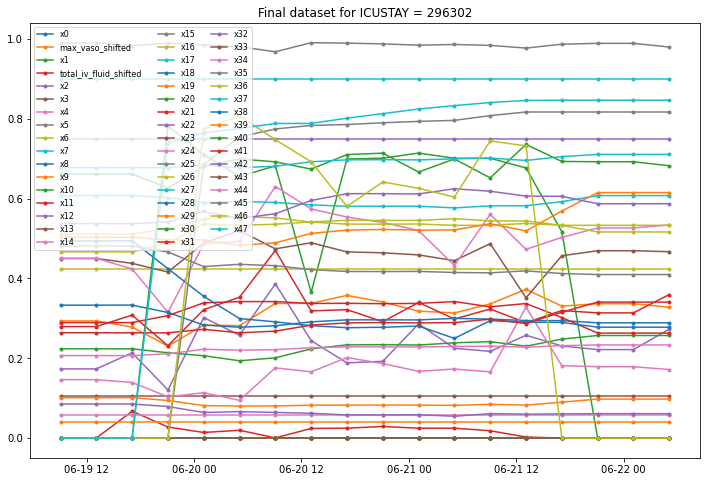

In [82]:
# Limit plot to one ICU stay
icustay_id = random.choice(list(data_train_df['episode'].unique()))
icustay_df = data_train_df[data_train_df['episode'] == icustay_id]

# Plot interesting columns
plt.figure(figsize=(12, 8))
for col in icustay_df.columns:
    if col not in EXCLUDE + ['episode']:
        plt.plot(icustay_df['timestep'], icustay_df[col], label=col, marker='.')
        
plt.title('Final dataset for ICUSTAY = %s' % icustay_id)
plt.legend(ncol=3, prop={'size': 8})
plt.show()

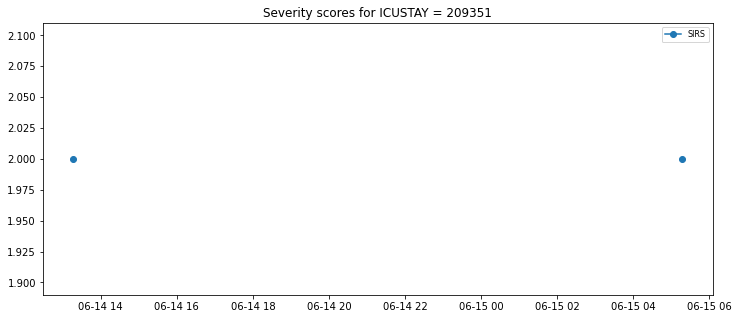

In [83]:
# Limit plot to one ICU stay
icustay_id = random.choice(list(data_train_df['episode'].unique()))
icustay_df = data_train_df[data_train_df['episode'] == icustay_id]

sirs_scores = icustay_df['state_sirs'].values
sirs_scores[sirs_scores < 0] = np.NaN

plt.figure(figsize=(12, 5))
plt.plot(icustay_df['timestep'], sirs_scores, label='SIRS', marker='o')
        
plt.title('Severity scores for ICUSTAY = %s' % icustay_id)
plt.legend(ncol=3, prop={'size': 8})
plt.show()

### General Statistics

In [84]:
train_df = pd.read_csv(OUTPUT_DIR + '/mimic-iii_train.csv')
print('Admissions:')
print('Train:', len(data_train_df['episode'].unique()))
print('Valid:', len(data_valid_df['episode'].unique()))
print('Test: ', len(data_test_df['episode'].unique()))

Admissions:
Train: 10524
Valid: 1503
Test:  3008


In [85]:
actionable_episodes = (train_df.groupby('episode')['action'].max() > 0).sum()
print('Admissions with actions:', actionable_episodes)

Admissions with actions: 10524


In [86]:
groups = train_df.groupby('episode', sort=False)['action'].max() > 0
icustay_ids = groups.index[groups.values]
icustay_ids

Int64Index([200003, 200030, 200035, 200036, 200061, 200063, 200065, 200075,
            200085, 200087,
            ...
            299919, 299921, 299925, 299948, 299949, 299950, 299988, 299992,
            299995, 299998],
           dtype='int64', name='episode', length=10524)